# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Датасет содержит следующие колонки: 
    
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**
Price — цена (евро)

Импортируем необходимые библиотеки

In [1]:
import re

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split)
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                    StandardScaler, MinMaxScaler)


import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
!pip install --upgrade scikit-learn

## Подготовка данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Изменим наименования столбцов на более "Питоновские"

In [5]:
data.columns = data.columns.str.replace('([A-Z])', r'_\1', regex=True).str.lower()
data.columns = data.columns.str.lstrip('_')

Рассчитаем количество пропусков

In [6]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

На цену автомобиля **не влияют** следующие признаки: 

1. DateCrawled — дата скачивания анкеты из базы
2. DateCreated — дата создания анкеты
3. PostalCode — почтовый индекс владельца анкеты (пользователя)
4. LastSeen — дата последней активности пользователя
3. NumberOfPictures — количество фотографий автомобиля
6. В ходе рассмотрения данных было обнаружено, что не нужно брать месяц регистрации, т.к. месяцы распределены равномерно.

Для дальнейшей работы определим максимальную дату выгрузки данных, остальные автомобили, далее этой даты "ИЗ БУДУЩЕГО"

In [7]:
data['date_crawled'].max()

'2016-04-07 14:36:58'

In [8]:
data = data.drop(columns=['date_created', \
                          'date_crawled', 'postal_code','last_seen','number_of_pictures','registration_month'], axis=1)

In [9]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Посмотрим на категориальные переменные для установления наличия неявных дубликатов

In [10]:
for i in data.select_dtypes(include=['object', 'category']).columns:
    print(data[i].name)
    print(data[i].unique())

vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
gearbox
['manual' 'auto' nan]
model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore

Обнаружены неявыне дубликаты petrol и gasoline, range_rover и rangerover

In [11]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')
data['model'] = data['model'].replace('range_rover', 'rangerover')

Найдем явные дубликаты:

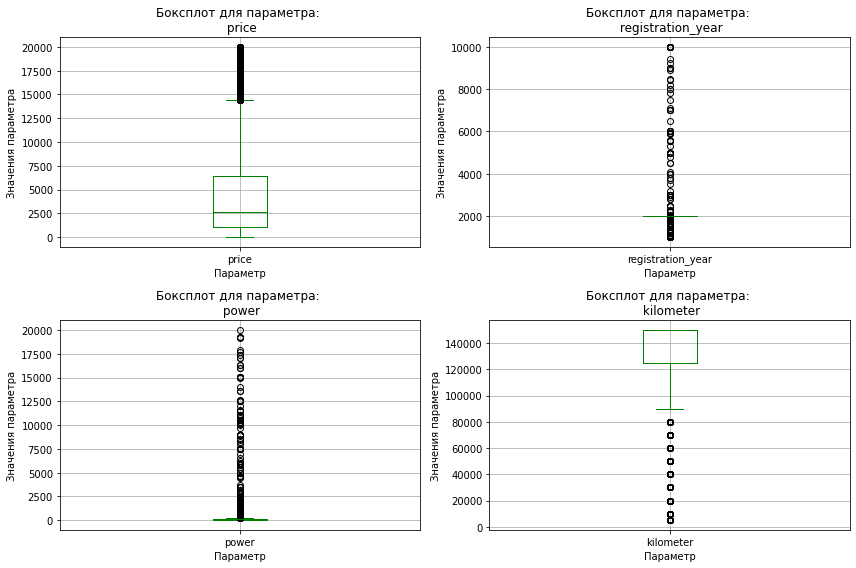

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

numeric_cols = data.select_dtypes(include=['number']).columns

for i, numeric_col in enumerate(numeric_cols):
    ax = axes[i]
    data.boxplot(column=numeric_col, ax=ax, color='green')
    
    ax.set_xlabel('Параметр')
    ax.set_ylabel('Значения параметра')
    ax.set_title(f'Боксплот для параметра: \n {numeric_col}')
   
plt.tight_layout()
plt.show()

Аномалии в данных обнаружены в: 1) Год регистрации 2) Мощность | необходимо отдельно посмотреть на эти данные. 

In [13]:
data['registration_year'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Удалим значения, где год < 1900 и > 2016

In [14]:
data = data.query('registration_year >=1900 and registration_year <= 2016')
data['registration_year'].describe()

count    339773.000000
mean       2002.482222
std           7.091181
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Аномалии в годе регистрации удалены

In [15]:
data['power'].describe()

count    339773.000000
mean        111.002711
std         186.879221
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [16]:
data.query('power>500').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
4060,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
6637,600,small,1996,manual,603,corsa,150000,petrol,opel,yes
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
7720,1500,small,2000,manual,1400,NaN,150000,petrol,honda,NaN
8057,500,small,2002,manual,620,ypsilon,150000,petrol,lancia,NaN


Судя по данному списку автомобилей мы имеем действительно дело с аномалиями, а не с истинными значениями. Например, есть такая история:

"Рассекречен гиперкар Zenvo Aurora с самым мощным в мире V12 и максималкой 451 км/ч. 16 августа 2023. Датская фирма Zenvo рассекретила гиперкар Aurora, оснащённый самым мощным в мире двигателем V 12. С электрическим довеском силовая установка выдаёт до **1850 лошадиных сил** и позволяет развивать до 451 км/ч. ДВС объёмом 6,6 литра с четырьмя турбинами имеет мощность 1250 лошадиных сил."

Очень сомневаюсь, что этот автомобиль будет продаваться на таком сайте, поэтому, можно удалить все строки, где у автомобилей мощность более 500 л.с. (это даже с запасом)

Таким же образом запросим автомобили с минимальной мощностью, по таким данным:

Мощность некоторых малолитражных автомобилей:

* Nissan March. Мощность двигателя — 80–110 л. с.
* Subaru Pleo. Мощность — от 38 до 58 л. с. 
* Subaru Trezia. Мощность — 95–99 л. с.
* Suzuki Kei. Мощность — от 44 до 64 л. с.
* Smart Fortwo. Мощность двигателей — от 71 до 109 л. с.
* Kia Picanto. По большей части оснащается двигателем объёмом 1 литр мощностью 67 л. с. Также есть варианты на 1,3 литра мощностью 85 лошадиных сил.

Режем все, что меньше 50 л.с.

In [17]:
data = data.query('power>50 and power<500')
data['power'].describe()

count    292701.000000
mean        122.997171
std          52.372497
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         490.000000
Name: power, dtype: float64

In [18]:
data = data.query('price>500')

In [19]:
data.isna().sum()

price                    0
vehicle_type          7826
registration_year        0
gearbox               3995
power                    0
model                 8949
kilometer                0
fuel_type            11740
brand                    0
repaired             34427
dtype: int64

Заполнение пропусков: На мой взгляд, заполнять пропуски медианным значением нельзя. Заполним пропуски заглушкой unknown, при работе в пайплайнах.

In [20]:
data.describe()

,price,registration_year,power,kilometer
count,267795.000000,267795.000000,267795.000000,267795.000000
mean,5286.018010,2003.345996,125.505667,127675.684759
std,4615.146251,6.189333,52.564864,36893.569047
min,501.000000,1910.000000,51.000000,5000.000000
25%,1699.000000,2000.000000,87.000000,125000.000000
50%,3666.000000,2004.000000,116.000000,150000.000000
75%,7500.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,490.000000,150000.000000


Выполним небольшой анализ, чтобы лучше понимать данные:
    

In [21]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [22]:
data_analysis = data[['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'model']]
data_analysis.head()

,vehicle_type,gearbox,fuel_type,brand,repaired,model
1,coupe,manual,petrol,audi,yes,NaN
2,suv,auto,petrol,jeep,NaN,grand
3,small,manual,petrol,volkswagen,no,golf
4,small,manual,petrol,skoda,no,fabia
5,sedan,manual,petrol,bmw,yes,3er


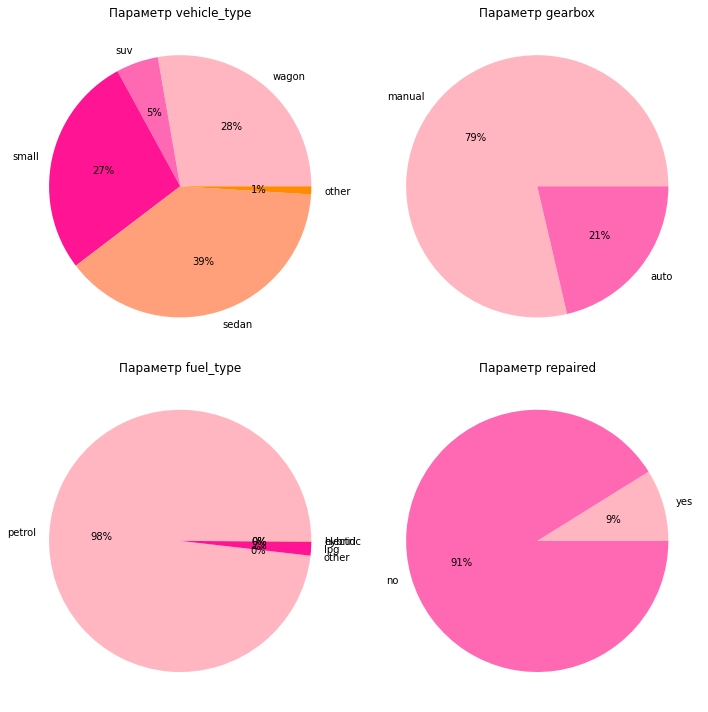

In [23]:
colors_earth = ['#FFB6C1', '#FF69B4', '#FF1493', '#FFA07A', '#FF8C00', '#FF4500', '#FF6347', '#FFD700']
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

features = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

for i, feature in enumerate(features):
    data_analysis.pivot_table(index=feature, values='model', aggfunc='count').\
    sort_values(by=feature, ascending=False).head(5).plot(
        kind='pie',
        figsize=(5, 5),
        grid=False,
        title=None,
        subplots=True,
        autopct='%.0f%%',
        colors=colors_earth,
        ax=axs[i]  
    )
    axs[i].set_ylabel(None)
    axs[i].set_title(f'Параметр {feature}')
    axs[i].get_legend().remove()

    
plt.tight_layout()
plt.show()

На рынке превалируют седаны, с ручной коробкой передач, без ДТП (не бита, не крашена, ездила девушка или пенсионер)

**Вывод:** в ходе работы были обработаны пропуски, дубликаты, удалены аномалии, что сделало данные более пригодными для обучения

Перед машинным обучением удалим дубликаты:

In [24]:
data.duplicated().sum()

36126

In [25]:
data[data.duplicated(keep=False)].head()


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
14,17999,suv,2011,manual,190,navara,70000,petrol,nissan,no
20,10400,coupe,2009,manual,160,scirocco,100000,petrol,volkswagen,no
27,6900,sedan,2008,manual,99,civic,60000,petrol,honda,no
46,7999,sedan,2007,manual,177,1er,150000,petrol,bmw,no


Явные дубликаты как бы есть, но не ясно, являютсмя ли они дубликатами, или это просто так вышло - удалим

In [26]:
data = data.drop_duplicates()

## Обучение моделей

Приведем признаки к категориальным для модели LBM

In [27]:
data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = \
data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']].astype('category')


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231669 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              231669 non-null  int64   
 1   vehicle_type       224165 non-null  category
 2   registration_year  231669 non-null  int64   
 3   gearbox            227835 non-null  category
 4   power              231669 non-null  int64   
 5   model              223117 non-null  category
 6   kilometer          231669 non-null  int64   
 7   fuel_type          220273 non-null  category
 8   brand              231669 non-null  category
 9   repaired           199796 non-null  category
dtypes: category(6), int64(4)
memory usage: 10.4 MB


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1),
    data['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer', ]

Заполняем пропуски заглушкой

In [30]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [31]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough')


In [32]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(5, 7),  
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },

    {
        
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 'passthrough'],
    
    },

    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': [31, 50],
        'models__learning_rate': [0.01, 0.1],  
        'preprocessor__num': [StandardScaler(), 'passthrough'],
    }
]


In [33]:
start_time = time.time()

random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=30, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

end_time = time.time()

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели:', abs(random_search.best_score_))
print(f'Время потраченное на подбор модели и обучение: {end_time - start_time:.4f} секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fue

In [34]:
best_pipeline = random_search.best_estimator_
best_model = best_pipeline.named_steps['models']


In [35]:
random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', 'passthrough',
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models', LGBMRegressor(num_leaves=50, random_state=42))])

In [36]:
print(f'Параметры лучшей модели по метрике {random_search.best_params_}')

Параметры лучшей модели по метрике {'preprocessor__num': 'passthrough', 'models__num_leaves': 50, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}


**Вывод:** На данных была обучена и выбрана модель, имеющая следующие параметры  {'preprocessor__num': StandardScaler(), 'models__num_leaves': 50, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}, модель выбиралась по метрике RMSE.



## Анализ моделей

Отсортируем по модели и выберем наиболее удачный алгоритм

Наилучшее сочетание минимумов метрики и времени обучения демострирует алгоритм LGBMRegressor

Используем данные по обучению cv_results, выведем отсортированную таблицу по метрике и времени работы модели:

In [37]:
result = pd.DataFrame(random_search.cv_results_)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

result['mean_test_score'] = abs(result['mean_test_score'])

result['model'] = result['params'].apply(lambda x: x['models'].__class__.__name__)

Параметры лучшей модели по метрике и по времени:

Время: 0.56

Метрика: 1710.755293
    
Параметры: **{'preprocessor__num': 'passthrough', 'models__num_leaves': 31, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}**	


In [38]:
best_indices = result.groupby('model')['mean_test_score'].idxmin()
best_models = result.iloc[best_indices]
display(best_models[['model','params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']])

,model,params,mean_test_score,mean_fit_time,mean_score_time
10,DecisionTreeRegressor,"{'preprocessor__num': StandardScaler(), 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}",3712.870610,0.905322,0.216686
21,LGBMRegressor,"{'preprocessor__num': 'passthrough', 'models__num_leaves': 50, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}",1676.733369,52.402588,0.698376
12,LinearRegression,"{'preprocessor__num': StandardScaler(), 'models': LinearRegression()}",2654.319355,14.519855,0.356195


Проверка качества лучшей модели на тестовой выборке:


In [92]:
start_time = time.time()
y_pred = random_search.predict(X_test)
end_time = time.time()
print(f'Метрика RMSE на тестовой выборке: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Время потраченное на применение модели: {end_time - start_time:.4f} секунд')

Метрика RMSE на тестовой выборке: 1648.7606645128596
Время потраченное на применение модели: 0.9685 секунд


**Вывод: модель работает качественно, т.к. значение метрики RMSE и на тренировочной и на тестовой выборке менее 2500, что соответствует условиям задачи, обучение модели с отбором гиперпараметров показало, что наибольшую пригодность для текущей задачи показывает метод LGBMRegressor.**

* Время потраченное на отбор и обучение составляло примерно 8 минут
* Время применения модели менее секунды